# Projeto 2 - Transfer Learning

SCC5809 - Redes Neurais Artificiais e Aprendizado Profundo

**Nome**:  - **NUSP**: 

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

## Pré-processamento

In [ ]:
dataset_file = 'cats_and_dogs_filtered.zip'

In [ ]:
if not os.path.exists(os.path.join(os.getcwd(), 'cats_and_dogs_filtered.zip')):
  print("Dataset file not present. Downloading...")
  !wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
  print("Finished downloading!")
else:
  print("Dataset file already present in current directory.")
if not os.path.isdir('cats_and_dogs_filtered'):
  print("Dataset folder not extracted yet. Extracting...")
  !unzip cats_and_dogs_filtered.zip
  print("Dataset folder extracted!")
else:
  print("Dataset folder already extracted onto current directory.")

Dataset file not present. Downloading...
--2024-10-28 00:27:23--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.26.207, 172.217.204.207, 172.217.203.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.26.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   134MB/s    in 0.5s    

2024-10-28 00:27:24 (134 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]

Finished downloading!
Dataset folder not extracted yet. Extracting...
Archive:  cats_and_dogs_filtered.zip
   creating: cats_and_dogs_filtered/
  inflating: cats_and_dogs_filtered/vectorize.py  
   creating: cats_and_dogs_filtered/validation/
   creating: cats_and_dogs_filtered/train/
   creating: cats_and_dogs_filtered/validation/dogs/
  inflating: c

In [ ]:
# Pastas de treino e validação
train_dir = 'cats_and_dogs_filtered/train'
test_dir = 'cats_and_dogs_filtered/validation'

# Geradores de dados com redimensionamento e normalização das imagens
train_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Carregamento das imagens de treino e validação
# Redimensionar para 160x160
# Problema de classificação binária
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(160, 160),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(160, 160),
    batch_size=32,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Carregando o modelo MobileNetV2 e preparando-o

In [ ]:
base_mnetv2 = MobileNetV2(input_shape=(160, 160, 3), weights='imagenet')
base_mnetv2.summary()

Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 160, 160, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 80, 80, 32)     │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 80, 80, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 80, 80, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 80, 80, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 80, 80, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 80, 80, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 80, 80, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 80, 80, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 80, 80, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 80, 80, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 80, 80, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 81, 81, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 40, 40, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 3,538,984 (13.50 MB)

 Trainable params: 3,504,872 (13.37 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [ ]:
# Modelo base MobileNetV2, sem camadas superiores e com pesos já treinados da ImageNet
base_mobilenetv2 = MobileNetV2(input_shape=(160, 160, 3), include_top=False, weights='imagenet')
# Congelar as camadas do modelo base
base_mobilenetv2.trainable = False
# Verificar se o congelamento ocorreu
base_mobilenetv2.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 160, 160, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 80, 80, 32)     │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 80, 80, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 80, 80, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 80, 80, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 80, 80, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 80, 80, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 80, 80, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 80, 80, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 80, 80, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 80, 80, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 80, 80, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 81, 81, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 40, 40, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
input_shape = (160, 160, 3)
inputs = layers.Input(shape=input_shape)

x = base_mobilenetv2(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
preds = layers.Dense(1,activation='sigmoid')(x)

model = models.Model(inputs, preds)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Sumário do modelo
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_160 (Functional)    │ (None, 5, 5, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           1,281 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Treinando o modelo

In [ ]:
# Treinando o modelo
history = model.fit(train_generator, validation_data=test_generator, epochs=5)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 70s 993ms/step - accuracy: 0.7972 - loss: 0.4163 - val_accuracy: 0.9530 - val_loss: 0.1312
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 62s 984ms/step - accuracy: 0.9596 - loss: 0.1069 - val_accuracy: 0.9660 - val_loss: 0.1038
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 60s 955ms/step - accuracy: 0.9692 - loss: 0.0817 - val_accuracy: 0.9640 - val_loss: 0.0957
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 61s 960ms/step - accuracy: 0.9842 - loss: 0.0598 - val_accuracy: 0.9640 - val_loss: 0.0902
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 83s 980ms/step - accuracy: 0.9849 - loss: 0.0463 - val_accuracy: 0.9640 - val_loss: 0.0905


In [ ]:
def plotTrainingPerformance(history):
  epochs_vec = [i for i in range(len(history.history['loss']))]
  plt.plot(epochs_vec, history.history['accuracy'], label='Train accuracy')
  plt.plot(epochs_vec, history.history['val_accuracy'], label='Validation accuracy')

  plt.legend(title='Sets')
  plt.legend(loc='lower right')
  plt.title('Accuracy over epochs')
  plt.tight_layout()
  plt.show(True)
  return

In [ ]:
history

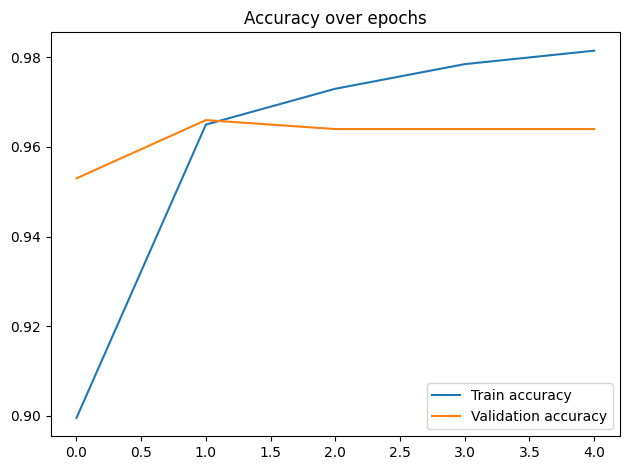

In [ ]:
plotTrainingPerformance(history)

## Testando com imagens da internet

Adicione a pasta com as imagens obtidas na internet para que esse passo funcione.

A pasta é `custom_test_dogs_cats.zip`.

In [ ]:
if not os.path.isdir('custom_test_dogs_cats'):
  print("Dataset folder not extracted yet. Extracting...")
  !unzip custom_test_dogs_cats.zip
  print("Dataset folder extracted!")
else:
  print("Dataset folder already extracted onto current directory.")

Dataset folder already extracted onto current directory.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Diretório de teste (organizado em subpastas "cats" e "dogs")
custom_test_dir = './custom_test_dogs_cats'

# Criar gerador de dados para o conjunto de teste
custom_test_datagen = ImageDataGenerator(rescale=1.0/255.0)  # Escalar as imagens para [0, 1]

# Carregar as imagens de teste
custom_test_generator = custom_test_datagen.flow_from_directory(
    custom_test_dir,
    target_size=(160, 160),  # Redimensionar para 160x160
    batch_size=6,            # Testar com as 6 imagens ao mesmo tempo
    class_mode='binary'      # Classificação binária
)

# Avaliar o modelo no conjunto de teste
loss, accuracy = model.evaluate(custom_test_generator)

# Exibir a acurácia
print(f"Acurácia no conjunto de teste: {accuracy * 100:.2f}%")

Found 6 images belonging to 2 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 1.0000 - loss: 0.0102


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Acurácia no conjunto de teste: 100.00%
